# Disease Classifier
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=lungCancerBinaryClassifier.ipynb)
- ?? what is the attribution for the Kim lab

## Overview
We do not have enough lung cancer examples to train a binary classifier. The model did not 
learning anything. simply predicting all example to be 'not lung cancer' will have about 93% 
accuracy. Work around train  multinomial classifier on the category label.  

In [1]:
import pathlib as pl

import logging
from   setupLogging import setupLogging
configFilePath = setupLogging( default_path=pl.Path('../src/logging.ini.json'))
configFilePath = setupLogging( default_path=pl.Path('../src/logging.test.ini.json'))
logger = logging.getLogger("notebook")
logger.info("using logging configuration file:{}".format(configFilePath))

from dataUtilities.TCGA_Target_GTex import TCGA_Target_GTex

import matplotlib.pyplot as plt
# import matplotlib.patches as mplpatches

from matplotlibUtilities.histogram import Histogram as muHistogram
import matplotlibUtilities.utilities as mu
import numpy as np
import pandas as pd

# https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
# display(HTML(' <span style="color:red">the title is: <h1>Hello, world!</h1> </span>  '))
from IPython.display import display, HTML

# fix random seed for reproducibility
theMeaningOfLife = 42
np.random.seed(theMeaningOfLife)

[INFO <ipython-input-1-bf4d12904823>:8 - <module>()] using logging configuration file:../src/logging.test.ini.json


## Load Data

In [2]:
dataDir = pl.Path("../data")
if not dataDir.exists() :
    dataDir.mkdir()
    
loader = TCGA_Target_GTex(dataDir)
# the first time you run will be slow, downloads data, and creates a tidy data set
XDF, YDF = loader.loadTCGA_Target_GTex()   

[INFO utils.py:129 - _init_num_threads()] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.


In [3]:
print("YDF.columns\n{}".format(YDF.columns))

YDF.columns
Index(['category', 'disease', 'primary_site', 'sample_type', 'gender', 'study',
       'tumor_normal'],
      dtype='object')


In [4]:
diseaseCountsSeries = YDF.loc[ :, 'category' ].value_counts()
diseaseCountsSeries

Breast Invasive Carcinoma              1212
Kidney Clear Cell Carcinoma             603
Lung Adenocarcinoma                     574
Thyroid Carcinoma                       571
Head & Neck Squamous Cell Carcinoma     564
                                       ... 
Bladder                                   9
Cervix - Ectocervix                       6
Fallopian Tube                            5
Kidney, Rhabdoid Tumor                    5
Cervix - Endocervix                       4
Name: category, Length: 93, dtype: int64

### <span style="color:red">AEDWIP: data?</span>
Should we drop categories that do not have many example, like Bladder?

All the GTEX example where known to be normal. Where biopsy from people being screen for cancer?

Should we lump LungCancerRows ?

what do the 'category', 'disease', and 'primary site' mean?

In [5]:
lungCancerPSRowsSeries     = YDF['primary_site'].str.contains('lun', case=False)
lungCancerCatRowsSeries    = YDF['category'    ].str.contains('lun', case=False)
lungCancerDieaseRowsSeries = YDF['disease'     ].str.contains('lun', case=False)

print("for lung relelated examples, are the primary_site and category features the same:? {}"\
      .format(pd.Series.equals(lungCancerPSRowsSeries, lungCancerCatRowsSeries) ))

print("for lung relelated examples, are the category  and disease features the same:? {}"\
      .format(pd.Series.equals(lungCancerCatRowsSeries, lungCancerDieaseRowsSeries) ))

def numDiffs(df1, df2):
    d = lungCancerPSRowsSeries == lungCancerCatRowsSeries
    numSame = d.sum()
    n = lungCancerPSRowsSeries.size
    numDiff = n - numSame
    return numDiff
    
d = numDiffs( lungCancerPSRowsSeries, lungCancerCatRowsSeries )
print("number of diffs:{}".format(d))

# use short names
lungCancerPSRowsSeries = None
lungCancerRows = lungCancerCatRowsSeries
lungCancerCatRowsSeries = None

for lung relelated examples, are the primary_site and category features the same:? True
for lung relelated examples, are the category  and disease features the same:? True
number of diffs:0


In [6]:
# Do categories contain normal and cancer examples
lungMetaDF = YDF[lungCancerRows]
lungMetaDF

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-111CU-0326-SM-5GZXO,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-111FC-1126-SM-5GZWU,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-111VG-0726-SM-5GIDC,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-111YS-0626-SM-5GZXV,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-1122O-0126-SM-5GICA,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal
...,...,...,...,...,...,...,...
TCGA-O2-A52V-01,Lung Squamous Cell Carcinoma,Lung Squamous Cell Carcinoma,Lung,Primary Tumor,Female,TCGA,Tumor
TCGA-O2-A52W-01,Lung Squamous Cell Carcinoma,Lung Squamous Cell Carcinoma,Lung,Primary Tumor,Male,TCGA,Tumor
TCGA-O2-A5IB-01,Lung Squamous Cell Carcinoma,Lung Squamous Cell Carcinoma,Lung,Primary Tumor,Female,TCGA,Tumor


In [7]:
c = lungMetaDF.groupby('category').count()
print(type(c))
print(c.columns)
print(c.index)
print(c.values)
print(c.iloc[:, 0].values)

<class 'pandas.core.frame.DataFrame'>
Index(['disease', 'primary_site', 'sample_type', 'gender', 'study',
       'tumor_normal'],
      dtype='object')
Index(['Lung', 'Lung Adenocarcinoma', 'Lung Squamous Cell Carcinoma'], dtype='object', name='category')
[[288 288 288 288 288 288]
 [574 574 574 574 574 574]
 [548 548 548 548 548 548]]
[288 574 548]


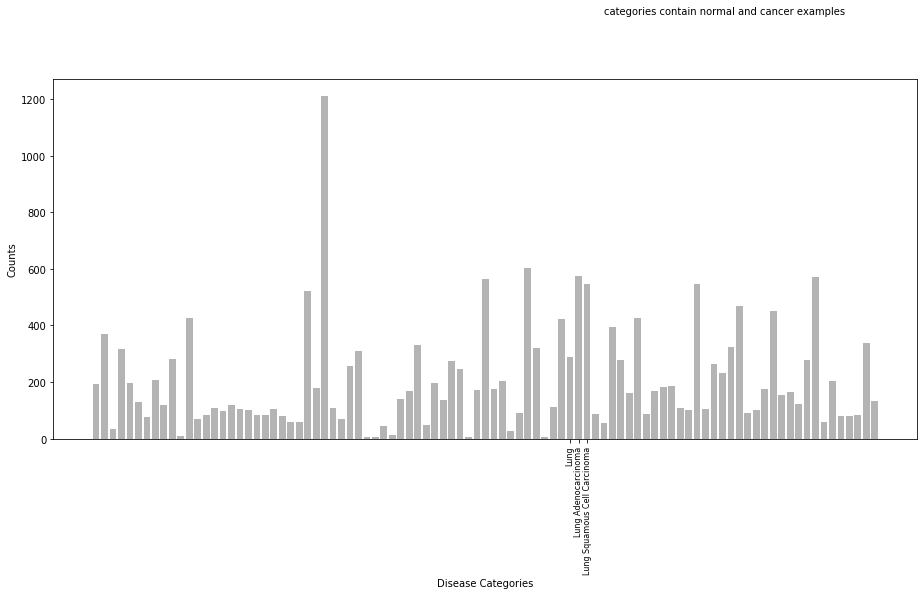

In [8]:
   figureWidthInInches = 12
figureHeightInInches = 5
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))

panelWidthInInches = figureWidthInInches
panelHeightInInches = figureHeightInInches
leftRelativeSize = 0
bottomRelativeSize = 1
panel = mu.createPanel(fig, panelWidthInInches, panelHeightInInches,
                leftRelativeSize, bottomRelativeSize)
    
barNames = YDF.groupby('category')['disease'].count().index.to_numpy()
barHeights = YDF.groupby('category')['disease'].count().to_numpy()
xticksIdxList = [i for  i,str in enumerate(barNames) if 'Lung' in str ]

mu.fancyBarGraph(panel, barHeights, barNames, xticksIdxList)

panel.set_xlabel("Disease Categories")
panel.set_ylabel("Counts")
panel.text(60, 1500, "categories contain normal and cancer examples")
    
plt.show()

### Data Summary
- 93 different disease categories
- many only have a few examples


### <span style="color:red">not all disease categories have normal and cancer examples</span>
only 25 shared categories

In [9]:
# YDF.loc[ YDF['tumor_normal'] == 'Normal']
normalDF = YDF.loc[ YDF['tumor_normal'] == 'Normal']
normalDiseaseCounts = normalDF.groupby('category')['disease'].count().to_numpy()
print(normalDiseaseCounts[0:5])
normalBarNames = normalDF.groupby('category')['disease'].count().index.to_numpy()
print(normalBarNames[0:5])
print(len(normalBarNames))

[318 197 128 207 118]
['Adipose - Subcutaneous' 'Adipose - Visceral (Omentum)' 'Adrenal Gland'
 'Artery - Aorta' 'Artery - Coronary']
80


In [10]:
tumorDF = YDF.loc[ YDF['tumor_normal'] == 'Tumor']
tumorDiseaseCounts = tumorDF.groupby('category')['disease'].count().to_numpy()
print(tumorDiseaseCounts[0:5])
tumorBarNames = tumorDF.groupby('category')['disease'].count().index.to_numpy()
print(tumorBarNames[0:5])
print(len(tumorBarNames))

[194 369  32  77 407]
['Acute Lymphoblastic Leukemia' 'Acute Myeloid Leukemia'
 'Acute Myeloid Leukemia, Induction Failure Subproject'
 'Adrenocortical Cancer' 'Bladder Urothelial Carcinoma']
38


In [11]:
sharedDiseaseTypes = np.intersect1d(normalBarNames, tumorBarNames)
print(len(sharedDiseaseTypes))
sharedDiseaseTypes

25


array(['Bladder Urothelial Carcinoma', 'Breast Invasive Carcinoma',
       'Cervical & Endocervical Cancer', 'Cholangiocarcinoma',
       'Colon Adenocarcinoma', 'Esophageal Carcinoma',
       'Glioblastoma Multiforme', 'Head & Neck Squamous Cell Carcinoma',
       'Kidney Chromophobe', 'Kidney Clear Cell Carcinoma',
       'Kidney Papillary Cell Carcinoma',
       'Liver Hepatocellular Carcinoma', 'Lung Adenocarcinoma',
       'Lung Squamous Cell Carcinoma', 'Pancreatic Adenocarcinoma',
       'Pheochromocytoma & Paraganglioma', 'Prostate Adenocarcinoma',
       'Rectum Adenocarcinoma', 'Sarcoma', 'Skin Cutaneous Melanoma',
       'Stomach Adenocarcinoma', 'Thymoma', 'Thyroid Carcinoma',
       'Uterine Corpus Endometrioid Carcinoma', 'Wilms Tumor'],
      dtype=object)

In [12]:
# select data set
def selectSharedData(df, sharedDiseaseTypes):
    shareDiseaseDFRows = df['disease'].isin(sharedDiseaseTypes)
    sharedDF = df.loc[ shareDiseaseDFRows]
    sharedBarNames = sharedDF.groupby('category')['disease'].count().index.to_numpy()
    sharedBarHeights = sharedDF.groupby('category')['disease'].count().to_numpy()
    sharedXticksIdxList = [i for  i,str in enumerate(sharedBarNames) if 'Lung' in str ]
    return (sharedDF, sharedBarNames, sharedBarHeights, sharedXticksIdxList)

tumorBarPlotData = selectSharedData(tumorDF, sharedDiseaseTypes)
normalBarPlotData = selectSharedData(normalDF, sharedDiseaseTypes)

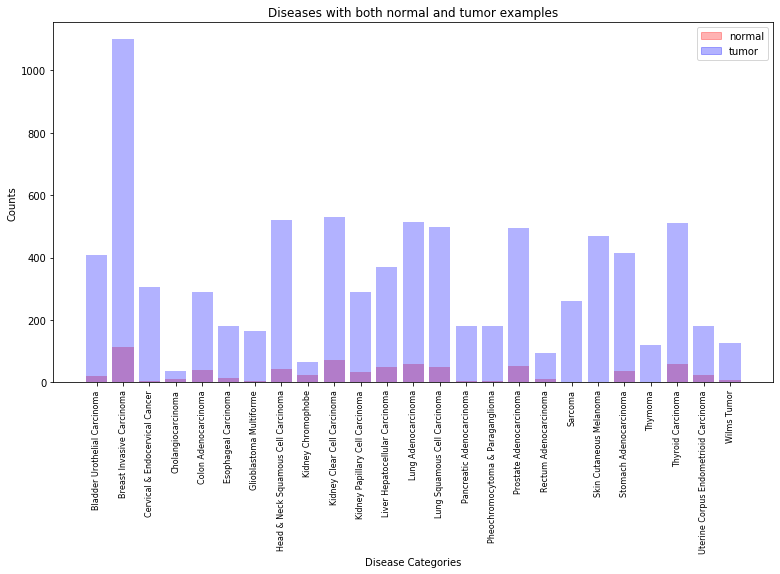

In [15]:
figureWidthInInches = 10
figureHeightInInches = 5
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))

panelWidthInInches = figureWidthInInches
panelHeightInInches = figureHeightInInches
leftRelativeSize = 0
bottomRelativeSize = 1
panel = mu.createPanel(fig, panelWidthInInches, panelHeightInInches,
                leftRelativeSize, bottomRelativeSize)
  
normalColor = (255,0,0)
alpha = 0.3
nDF, sharedNBarNames, sharedNBarHeights, sharedNXticksIdxList = normalBarPlotData
# display all desease names
xticksIdxList = list(range(len(sharedNBarNames)))
mu.fancyBarGraph(panel, sharedNBarHeights, sharedNBarNames, xticksIdxList,
             RGBTuple=normalColor, alpha=alpha)

tumorColor = (0,0,255)
sharedTDF, sharedTBarNames, sharedTBarHeights, sharedTrXticksIdxList = tumorBarPlotData
mu.fancyBarGraph(panel, sharedTBarHeights, sharedTBarNames, RGBTuple=tumorColor, alpha=alpha)

panel.set_xlabel("Disease Categories")
panel.set_ylabel("Counts")
#panel.text(60, 1500, "Diseases with both normal and tumor examples")
panel.set_title("Diseases with both normal and tumor examples")

colorMapTuples = [normalColor, tumorColor]
labels         = ['normal',    'tumor']
mu.addLegend(panel, colorMapTuples, labels, alpha=alpha)
    
plt.show()